In [1]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt


In [2]:
# Make it possible to import `pallets` from parent dir

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), '..'))
)
from pallets import images, datasets, models


# Prepare Data

1. Gather every unique color from the 10,000 punks and generate a one hot representation for each.

2. Instantiate a mapper to go from each color to its one hot representation and back.

3. Create dataloader for punks that represents its color data as one hot vectors.

In [3]:
# Unique colors for one punk

image = images.get_punk(0)
print("Image shape:", image.shape)

colors = images.one_image_colors(image)
print("Image colors:\n", colors)


Image shape: (24, 24, 4)
Image colors:
 [[0.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.3137255  0.4862745  0.2        1.        ]
 [0.3647059  0.54509807 0.2627451  1.        ]
 [0.37254903 0.11372549 0.03529412 1.        ]
 [0.68235296 0.54509807 0.38039216 1.        ]
 [1.         0.9647059  0.5568628  1.        ]]


In [4]:
# Unique colors for all punks

all_colors = images.get_punk_colors()
print(f"Found {len(all_colors)} colors")


Found 222 colors


In [5]:
# Mapper from color to one hot

mapper = datasets.ColorOneHotMapper(all_colors)
one_hot_encoded_image = datasets.convert_image_to_one_hot(image, mapper)
print("Image one hot:\n", one_hot_encoded_image[0][0])


Image one hot:
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [6]:
# Start with a color
test_color = all_colors[2]
print("Color:\n", test_color)

# Convert color to one hot
test_one_hot = mapper.get_one_hot(test_color)
print("One-hot encoding:\n", test_one_hot)

# Convert one hat back to original color
retrieved_color = mapper.get_color(test_one_hot)
print("Retrieved color:\n", retrieved_color)


Color:
 [0.        0.2509804 1.        1.       ]
One-hot encoding:
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Retrieved color:
 [0.        0.2509804 1.        1.       ]


In [7]:
# Punks Dataset

dataset = datasets.OneHotEncodedImageDataset(images.CPUNKS_IMAGE_DIR, mapper, test_size=2000)

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)
(type(dataset), len(dataset), dataset[0].shape)


(pallets.datasets.OneHotEncodedImageDataset, 10000, torch.Size([24, 24, 222]))

In [8]:
# Punks DataLoader

batch_size = 32
shuffle = True
num_workers = 4

train_loader = DataLoader(
    dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler
)
test_loader = DataLoader(
    dataset, batch_size=batch_size, num_workers=0, sampler=test_sampler
)

# dataloader = DataLoader(
#     dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0,
# )

test_punk = next(iter(train_loader))
test_punk.shape


torch.Size([32, 24, 24, 222])

# Train Model

In [9]:
# One Hot
autoencoder = models.OneHotAutoencoder()
train_losses, test_losses = models.train_onehot(autoencoder, train_loader, test_loader)

# # Simple Conv
# autoencoder = models.SimpleConvAutoencoder()
# models.train_simple_conv(autoencoder, dataloader)


Epoch [1/5]
  - train loss: 0.010373790318146349
  - test loss:  0.001457257187067871
Epoch [2/5]
  - train loss: 0.0014289987171068788
  - test loss:  0.0013938407276919674
Epoch [3/5]
  - train loss: 0.001306318332441151
  - test loss:  0.0012188382679596543
Epoch [4/5]
  - train loss: 0.001139265194768086
  - test loss:  0.0010437392047606409
Epoch [5/5]
  - train loss: 0.0009860445822123438
  - test loss:  0.0009475715526764


# Model Output to Image

In [10]:
# Reconstruct random data for test

# One Hot
if isinstance(autoencoder, models.OneHotAutoencoder):
    example_input = torch.rand(32, 24*24*222)
    reconstructed = autoencoder(example_input)
    print(reconstructed.shape)

# Simple Conv
else:
    example_input = torch.rand(32, 222, 28, 28)
    reconstructed = autoencoder(example_input)
    print(reconstructed.shape)  # Should be torch.Size([32, 222, 28, 28])


torch.Size([32, 24, 24, 222])


In [11]:
img_array = reconstructed.detach().cpu().numpy()

# Select the image at the specified index
one_hot_image = img_array[0]
one_hot_image[:,12,12]


array([2.16011070e-25, 1.07361689e-23, 3.45778621e-20, 2.75633044e-16,
       7.05600150e-26, 5.59118377e-12, 1.21725874e-16, 5.72738940e-27,
       3.06529064e-18, 3.50351521e-19, 1.51895579e-28, 4.75024774e-23,
       1.28333854e-17, 7.71135794e-22, 1.01335673e-21, 2.43669608e-17,
       2.34326718e-17, 1.36711529e-21, 3.91240687e-19, 6.37294156e-17,
       1.73352979e-22, 9.75999481e-26, 4.60806669e-24, 1.65151811e-20],
      dtype=float32)

In [12]:
# One Hot
if isinstance(autoencoder, models.OneHotAutoencoder):
    s = datasets.decode_to_rgb(one_hot_image, mapper)

# Simple Conv
else:
    reordered_array = np.transpose(one_hot_image, (1, 2, 0))
    s = datasets.decode_to_rgb(reordered_array, mapper)

s.shape


(24, 24, 4)

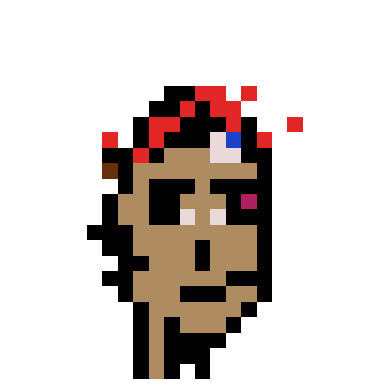

In [13]:
plt.imshow(s)
plt.axis('off')
plt.show()


# Tests

In [14]:
test_losses


[0.001457257187067871,
 0.0013938407276919674,
 0.0012188382679596543,
 0.0010437392047606409,
 0.0009475715526764]

In [15]:
train_losses


[0.010373790318146349,
 0.0014289987171068788,
 0.001306318332441151,
 0.001139265194768086,
 0.0009860445822123438]

<function matplotlib.pyplot.show(close=None, block=None)>

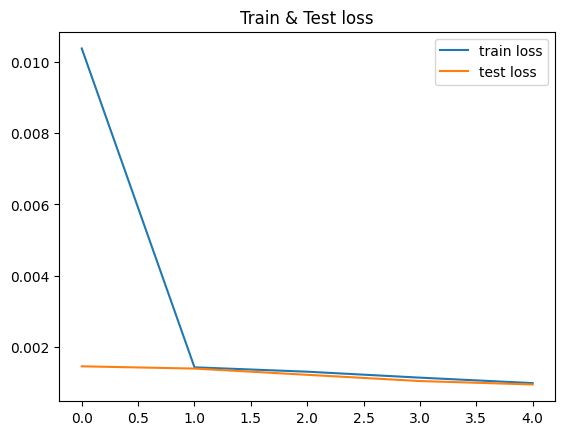

In [16]:
# plt.figure(figsize=(10,5))
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
